In [0]:
!pip install spectral
!pip3 install keras==2.2.4

In [0]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [0]:
import numpy as np
import random 
#import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, Conv3D, MaxPooling3D, ZeroPadding3D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Input
from keras.utils.np_utils import to_categorical
from sklearn.decomposition import PCA
from keras.optimizers import Adam, SGD, Adadelta, RMSprop, Nadam
import keras.callbacks as kcallbacks
from keras.regularizers import l2
import time
import collections
from sklearn import metrics, preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
def loadData(name):
    data_path = '/content/gdrive/My Drive/GAMO_gen/'
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'KSC':
        data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
        labels = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
    
    return data, labels

In [0]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 15

In [0]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [0]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [0]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [0]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [0]:
X , Y = loadData(dataset)

In [0]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [0]:
X, Y = createImageCubes(X, Y, windowSize=windowSize)
X.shape, Y.shape

((10249, 15, 15, 30), (10249,))

In [0]:
sz = X.shape[0]//10

In [0]:
 Y = to_categorical(Y)

In [0]:
X = X.reshape((X.shape[0],windowSize,windowSize,K,1))


In [0]:
train_X, test_X, train_Y, test_Y = splitTrainTestSet(X, Y, test_ratio)


In [0]:
#X.shape
#train_X, test_X = X[:160] , X[160:]
#train_Y, test_Y = Y[:160] , Y[160:]


In [0]:
val_X = test_X[:sz]
test_X = test_X[sz:]
val_Y = test_Y[:sz]
test_Y = test_Y[sz:]

In [0]:
train_X.shape

(3074, 15, 15, 30, 1)

In [0]:
KAPPA_RES_SS4 = []
OA_RES_SS4 = []
AA_RES_SS4 = []
TRAINING_TIME_RES_SS4 = []
TESTING_TIME_RES_SS4 = []
ELEMENT_ACC_RES_SS4 = np.zeros((1, 16))

In [0]:
#!rm se_resnet8_cbof.py
#!rm cbof.py

In [0]:
from google.colab import files
Utils = files.upload()

In [0]:
import se_resnet8_cbof
import cbof

In [0]:
def res4_model_ss():
    model_res4  = se_resnet8_cbof.SE_ResNet8((1, windowSize, windowSize, K),16,64)

    RMS = RMSprop(lr=0.0003)
    # Let's train the model using RMSprop
    model_res4.compile(loss='categorical_crossentropy', optimizer=RMS, metrics=['accuracy'])

    return model_res4 

In [0]:
import os
data_path = '/content/gdrive/My Drive/' # Add the desired path for output here
os.listdir(data_path)

['Model_SA',
 'Model_IP',
 'Model_PU',
 'predictions_IP_10.jpg',
 'predictions_IP_20.jpg',
 'predictions_IP_25.jpg',
 'predictions_IP_25_new.jpg',
 'foo.csv',
 'digits_tsne-generated_16_cluster.png',
 'digits_tsne-generated_16_cluster.pdf',
 'foo1.csv',
 'digits_tsne-generated_16_cluster_PU.pdf',
 'digits_tsne-generated_16_cluster_SA.pdf',
 'digits_tsne-generated_16_cluster_IP.pdf',
 'pu.csv']

In [0]:
from google.colab import files
fl = files.upload()

In [0]:
!unrar e -y utils3.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from utils3.rar

Extracting  averageAccuracy.py                                             2%  OK 
Extracting  doPCA.py                                                       4%  OK 
Extracting  modelStatsRecord.py                                           11%  OK 
Extracting  New Text Document.txt                                         12%  OK 
Extracting  normalization.py                                              14%  OK 
Extracting  Rawdata_3D_ResNet.py                                          42%  OK 
Extracting  Real3D_conv.py                                                67%  OK 
Extracting  ssrn_SS_IN.py                                                 96%  OK 
Extracting  zeroPadding.py                                                99%  OK 
All OK


In [0]:
import zeroPadding
import normalization
import doPCA
import modelStatsRecord
import averageAccuracy
import ssrn_SS_IN

In [0]:
for index_iter in range(1):
    print("# %d Iteration" % (index_iter + 1))

    # save the best validated model 
    
    best_weights_RES_path_ss4 = data_path+ 'Model_' + dataset +'/' + str(
        index_iter + 1) + '_NEW_KERNEL32_20_B_32_se.hdf5'

    

    # TRAIN_SIZE = len(train_indices)
    # print (TRAIN_SIZE)
    #
    # TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE - VAL_SIZE
    # print (TEST_SIZE)

    # print ("Validation data:")
    # collections.Counter(y_test_raw[-VAL_SIZE:])
    # print ("Testing data:")
    # collections.Counter(y_test_raw[:-VAL_SIZE])

    #train_assign = indexToAssignment(train_indices, whole_data.shape[0], whole_data.shape[1], PATCH_LENGTH)
    #for i in range(len(train_assign)):
    #    train_data[i] = selectNeighboringPatch(padded_data, train_assign[i][0], train_assign[i][1], PATCH_LENGTH)

    #test_assign = indexToAssignment(test_indices, whole_data.shape[0], whole_data.shape[1], PATCH_LENGTH)
    #for i in range(len(test_assign)):
    #    test_data[i] = selectNeighboringPatch(padded_data, test_assign[i][0], test_assign[i][1], PATCH_LENGTH)

    #train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2], 30)
    #test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2], 30)
    #val_X = val_X.reshape(val_X.shape[0], val_X.shape[1], val_X.shape[2], 30)

    #x_val = x_test_all[-VAL_SIZE:]
    #y_val = y_test[-VAL_SIZE:]

    #x_test = x_test_all[:-VAL_SIZE]
   # y_test = y_test[:-VAL_SIZE]

    # SS Residual Network 4 with BN
    model_res4_SS_BN = res4_model_ss()

    earlyStopping6 = kcallbacks.EarlyStopping(monitor='val_loss', patience=200, verbose=1, mode='auto')
    saveBestModel6 = kcallbacks.ModelCheckpoint(best_weights_RES_path_ss4, monitor='val_loss', verbose=1,
                                                save_best_only=True,
                                                mode='auto')

    tic6 = time.clock()
    print(train_X.shape, test_X.shape)
    history_res4_SS_BN = model_res4_SS_BN.fit(
        train_X, train_Y,
        validation_data=(val_X, val_Y),
        batch_size=32,
        nb_epoch=200, shuffle=True, callbacks=[earlyStopping6])#,saveBestModel6])
    toc6 = time.clock()

    tic7 = time.clock()
    loss_and_metrics_res4_SS_BN = model_res4_SS_BN.evaluate(
        test_X, test_Y,
        batch_size=32)
    toc7 = time.clock()

    print('3D RES_SS4 without BN Training Time: ', toc6 - tic6)
    print('3D RES_SS4 without BN Test time:', toc7 - tic7)

    print('3D RES_SS4 without BN Test score:', loss_and_metrics_res4_SS_BN[0])
    print('3D RES_SS4 without BN Test accuracy:', loss_and_metrics_res4_SS_BN[1])

    print(history_res4_SS_BN.history.keys())

    pred_test_res4 = model_res4_SS_BN.predict(test_X).argmax(axis=1)
    collections.Counter(pred_test_res4)
    gt_test = test_Y
    overall_acc_res4 = metrics.accuracy_score(pred_test_res4, gt_test.argmax(axis=1))
    confusion_matrix_res4 = metrics.confusion_matrix(pred_test_res4, gt_test.argmax(axis=1))
    each_acc_res4, average_acc_res4 = averageAccuracy.AA_andEachClassAccuracy(confusion_matrix_res4)
    kappa = metrics.cohen_kappa_score(pred_test_res4, gt_test.argmax(axis=1))
    KAPPA_RES_SS4.append(kappa)
    OA_RES_SS4.append(overall_acc_res4)
    AA_RES_SS4.append(average_acc_res4)
    TRAINING_TIME_RES_SS4.append(toc6 - tic6)
    TESTING_TIME_RES_SS4.append(toc7 - tic7)
    ELEMENT_ACC_RES_SS4[index_iter, :] = each_acc_res4

    print("3D RESNET_SS4 without BN training finished.")
    print("# %d Iteration" % (index_iter + 1))

modelStatsRecord.outputStats(KAPPA_RES_SS4, OA_RES_SS4, AA_RES_SS4, ELEMENT_ACC_RES_SS4,
                             TRAINING_TIME_RES_SS4, TESTING_TIME_RES_SS4,
                             history_res4_SS_BN, loss_and_metrics_res4_SS_BN, 16,
                             data_path+'Model_' + dataset + '/IN_train_RESNET8_KERNEL32_20_B_64_bcof_64_nooverlapping_7.txt',
                             data_path+'Model_' + dataset + '/IN_train_RESNET8_KERNEL32_20_B_32_IP_element_10_bcof_64_nooverlapping_7.txt')

# 1 Iteration
input shape: (None, 15, 15, 12, 64)
input shape: (None, 13, 13, 1, 64)
(?, 13, 13, 1, 64)
(?, 13, 13, 64)
(None, 13, 13, 64)
call
output
(None, 13, 13, 64)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 15, 15, 30, 1 0                                            
__________________________________________________________________________________________________
conv3d_17 (Conv3D)              (None, 15, 15, 12, 6 512         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 15, 15, 12, 6 256         conv3d_17[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 3074 samples, validate on 1024 samples
Epoch 1/200
3074/3074 [==============================] - 7s 2ms/step - loss: 7.3313 - acc: 0.1558 - val_loss: 9.4160 - val_acc: 0.2480
Epoch 2/200
3074/3074 [==============================] - 5s 1ms/step - loss: 6.0665 - acc: 0.2632 - val_loss: 7.8574 - val_acc: 0.1758
Epoch 3/200
3074/3074 [==============================] - 5s 1ms/step - loss: 4.1941 - acc: 0.3926 - val_loss: 6.1101 - val_acc: 0.2715
Epoch 4/200
3074/3074 [==============================] - 5s 1ms/step - loss: 2.6205 - acc: 0.4860 - val_loss: 3.1286 - val_acc: 0.4766
Epoch 5/200
3074/3074 [==============================] - 5s 1ms/step - loss: 1.8795 - acc: 0.6047 - val_loss: 1.3156 - val_acc: 0.8262
Epoch 6/200
3074/3074 [==============================] - 5s 1ms/step - loss: 1.5778 - acc: 0.6789 - val_loss: 1.2949 - val_acc: 0.8135
Epoch 7/200
3074/3074 [==============================] - 5s 1ms/step - loss: 1.2923 - acc: 0.7411 - val_loss: 1.1752 - val_acc: 0.8232
Epoch 8

In [0]:
hist1_val_acc = history_res4_SS_BN.history['val_acc']
hist1_val_loss = history_res4_SS_BN.history['val_loss']
hist1_acc = history_res4_SS_BN.history['acc']
hist1_loss = history_res4_SS_BN.history['loss']

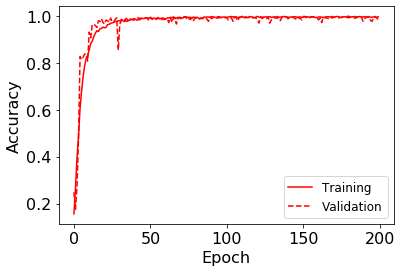

In [0]:
import matplotlib.pyplot as plt
import matplotlib
% matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

# summarize history for accuracy
f = plt.figure()

plt.plot(hist1_acc , color='red',linestyle='solid', label = 'Training')
plt.plot(hist1_val_acc , color='red',linestyle='dashed', label = 'Validation')

#plt.ylim(0, 3)   
#plt.xlim(0,50)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.legend(prop={'size': 12})


#plt.legend(['train', 'val'], loc='lower left')
plt.show()
#f.savefig("/content/gdrive/My Drive/Fuseacc.pdf")


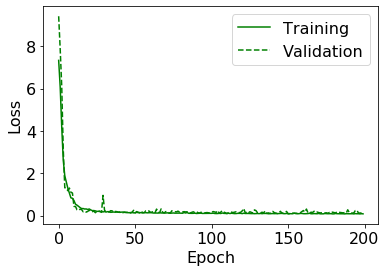

In [0]:
# summarize history for loss
# summarize history for accuracy
f = plt.figure()


plt.plot(hist1_loss , color='green',linestyle='solid', label = 'Training')
plt.plot(hist1_val_loss , color='green',linestyle='dashed', label = 'Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="best")

#plt.xlim(0,26)
#plt.legend(['train', 'val'], loc='upper left')
plt.show()
#f.savefig("/content/gdrive/My Drive/loss_new_UP_green.pdf")
